# COSC 437 Data Mining Lab Assignment 6 - Cross-Validation and Hyperparameter Tuning with Tree-Based Models

## Introduction
In this lab, we will continue working with the credit card default prediction dataset from Lab 5. Our focus will be on practicing **cross-validation** and **hyperparameter tuning** for decision trees and introducing **random forests** as an ensemble method. By the end of this lab, you will have a deeper understanding of how to evaluate and optimize supervised learning models.

Since the dataset has a class imbalance (as you observed in Lab 5), we will emphasize evaluation metrics like the sensitivity (recall), Area Under the ROC Curve (AUC), alongside accuracy to better assess model performance.

## Part I - Cross-Validation with Decision Trees
In Lab 5, you trained decision trees with different `max_depth` values and evaluated them using a single train-test split. Now, we will use **k-fold cross-validation** to obtain a more reliable estimate of model performance.

### Step 1 - Load and Preprocess the Data
Load the dataset and apply the same preprocessing steps as in Lab 5, including one-hot encoding for categorical features (`MARRIAGE`, `EDUCATION`). If you created a "MARRIAGE_SEX" cross feature in Lab 5, include it here as well. Separate the data into features (`X`) and target (`y`), where `y` is `default.payment.next.month`. Split the dataset into 85% training and 15% test. Make sure you specify `stratify=y` when splitting.

In [1]:
import pandas as pd
import numpy as np

In [2]:
# load data and define categories
data = pd.read_csv("Credit_Card.csv")
categorical_features = ['MARRIAGE', 'EDUCATION']

data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [3]:
# one-hot encoder
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_array = encoder.fit_transform(data[categorical_features])

encoded_data = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(categorical_features))
# drop the original categories and merge encoded featurs
data_encoded = data.drop(columns=categorical_features).join(encoded_data)
data_encoded.head()

,ID,LIMIT_BAL,SEX,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,default.payment.next.month,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6
0,1,20000.0,2,24,2,2,-1,-1,-2,-2,...,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2,120000.0,2,26,-1,2,0,0,0,2,...,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3,90000.0,2,34,0,0,0,0,0,0,...,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,4,50000.0,2,37,0,0,0,0,0,0,...,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,5,50000.0,1,57,-1,0,-1,0,0,0,...,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [4]:
# create a cross feature for MARRIAGE_SEX
data_encoded['MARRIAGE_SEX'] = data['MARRIAGE'].astype(str) + "_" + data['SEX'].astype(str)
data_encoded = data_encoded.join(pd.get_dummies(data_encoded['MARRIAGE_SEX'], prefix="MARRIAGE_SEX")).drop(columns=['MARRIAGE_SEX'])

In [5]:
from sklearn.model_selection import train_test_split

#split the test data
target = 'default.payment.next.month'
X = data_encoded.drop(columns=['ID', target])
y = data_encoded[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)

In [6]:
from sklearn.preprocessing import StandardScaler

# standardize the features using standard scaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Step 2 - Cross-Validation
For each `max_depth` in `[1, 2, 4, 8, 16, 32]`, train a decision tree classifier and evaluate its performance using **5-fold cross-validation**. Use `cross_val_score` from scikit-learn to compute:
   - Mean cross-validation **accuracy**.
   - Mean cross-validation **AUC**.
   - Mean cross-validation **sensitivity**.

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

In [8]:
# First define the hyperparameter values to be tested
max_depth_vals = [1, 2, 4, 8, 16, 32]

# store cross-validation results in a dict
cv_results = {'max_depth': [], 'accuracy': [], 'auc': [], 'sensitivity': []}

In [9]:
# loop through each hyperparameter value and perform cross validation
for depth in max_depth_vals:
    # init
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    
    # cross validaition
    accuracy = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
    auc = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()
    sensitivity = cross_val_score(model, X_train, y_train, cv=5, scoring='recall').mean()
    
    cv_results['max_depth'].append(depth)
    cv_results['accuracy'].append(accuracy)
    cv_results['auc'].append(auc)
    cv_results['sensitivity'].append(sensitivity)
    
    print(f"mean accuracy: {accuracy:.4f}")
    print(f"mean auc: {auc:.4f}")
    print(f"mean sensitivity: {sensitivity:.4f}")

# convert final results to a dataframe
cv_data = pd.DataFrame(cv_results)

mean accuracy: 0.8192
mean auc: 0.6430
mean sensitivity: 0.3269
mean accuracy: 0.8195
mean auc: 0.6942
mean sensitivity: 0.3131
mean accuracy: 0.8203
mean auc: 0.7429
mean sensitivity: 0.3618
mean accuracy: 0.8170
mean auc: 0.7470
mean sensitivity: 0.3561
mean accuracy: 0.7805
mean auc: 0.6423
mean sensitivity: 0.3859
mean accuracy: 0.7286
mean auc: 0.6134
mean sensitivity: 0.4221


### Step 3 - Visualization
Use three bar plots to visualize the cross-validation performance:
- On the first plot, compare the mean corss-validation accuracy
- On the second plot, compare the mean corss-validation AUC
- On the third plot, compare the mean corss-validation sensitivity

Hint: Use `cross_val_score` with `scoring='accuracy'` for accuracy, `scoring='roc_auc'` for AUC and `scoring='recall'` for sensitivity. You may need to run it multiple times for each metric.

In [10]:
import matplotlib.pyplot as plt

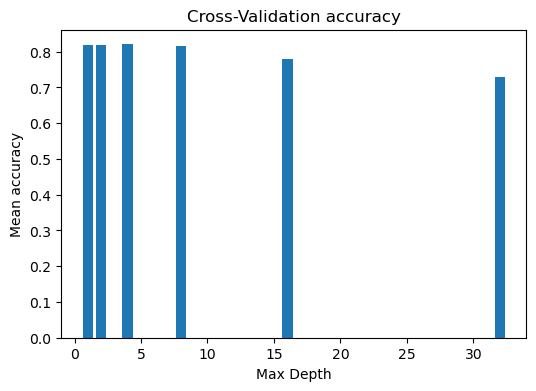

In [11]:
# accuracy plotting
plt.figure(figsize=(6,4))
plt.bar(cv_data['max_depth'], cv_data['accuracy'])
plt.xlabel('Max Depth')
plt.ylabel('Mean accuracy')
plt.title('Cross-Validation accuracy')
plt.show()

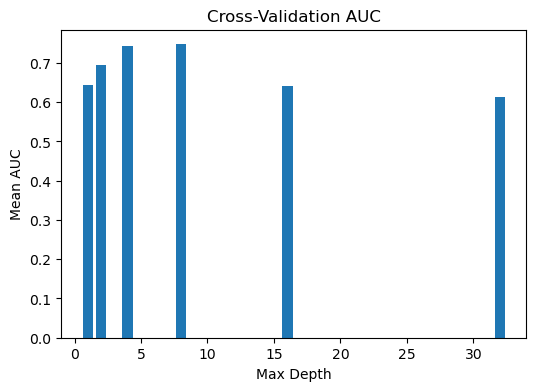

In [12]:
# auc plotting
plt.figure(figsize=(6, 4))
plt.bar(cv_data['max_depth'], cv_data['auc'])
plt.xlabel('Max Depth')
plt.ylabel('Mean AUC')
plt.title('Cross-Validation AUC')
plt.show()

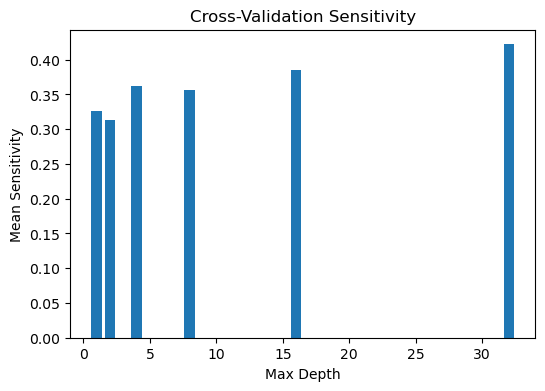

In [13]:
# sensitivity plotting
plt.figure(figsize=(6, 4))
plt.bar(cv_data['max_depth'], cv_data['sensitivity'])
plt.xlabel('Max Depth')
plt.ylabel('Mean Sensitivity')
plt.title('Cross-Validation Sensitivity')
plt.show()

### Step 4 - Train the Model
Through validation, we have estimates of the models' out-of-sample performance.  Notice that contrary to Lab 5, we haven't touched the test set yet. Now, let's use the best parameter, selected according to the cross-validation performance, to train a model on the entire training set. Since three metrics were collected, they may or may not agree on which parameter gives the best model. There is no universally correct way to rank the metrics, but you should justify your choice.

With the final model traind, report the performance on the test set.

In [14]:
# select the best parameter according to cross-validation performance
best_depth = cv_data.loc[cv_data['auc'].idxmax(), 'max_depth']

final_model = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
final_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=np.int64(8), random_state=42)

In [15]:
from sklearn.metrics import classification_report, roc_auc_score

# evaluate
y_pred = final_model.predict(X_test)
y_prob = final_model.predict_proba(X_test)[:, 1]

print("Classification Report on Test Set:", classification_report(y_test, y_pred))
print(f"Test AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

Classification Report on Test Set:               precision    recall  f1-score   support

           0       0.83      0.94      0.89      3505
           1       0.64      0.34      0.44       995

    accuracy                           0.81      4500
   macro avg       0.74      0.64      0.66      4500
weighted avg       0.79      0.81      0.79      4500

Test AUC Score: 0.7393


## Part II - Hyperparameter Tuning and Random Forests
In this part, we will train a random forest classifier for the task. Random forests are an ensemble of decision trees that can improve predictive performance. In class, we discussed that random forests are inherently resistant to overfitting, and we can often use out-of-bag performance in place of cross-validation for hyperparameter tuning. Here, we are going to see how that's the case.

### Step 1 - Baseline Random Forest
Train a random forest classifier with default parameters and evaluate its performance on the test set.

In [16]:
from sklearn.ensemble import RandomForestClassifier

In [17]:
# train a baseline model using random forest
rf_base_model = RandomForestClassifier(random_state=42)
rf_base_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [18]:
# evauluate
y_pred_rf = rf_base_model.predict(X_test)
y_prob_rf = rf_base_model.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print(f"Test AUC Score: {roc_auc_score(y_test, y_prob_rf):.4f}")

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.94      0.89      3505
           1       0.65      0.37      0.47       995

    accuracy                           0.82      4500
   macro avg       0.74      0.66      0.68      4500
weighted avg       0.80      0.82      0.80      4500

Test AUC Score: 0.7586


### Step 2 - Hyperparameter Tuning with Out-of-Bag Performance
Let's try different combinations of hyperparameters. For `n_estimators`, use 50, 100, 200; for `max_depth`, use 4, 6, 8, 10. Use a for-loop to train a random forest with each of the hyperparameter pairs. Make sure you enable `oob_score` and set it to `f1`. Pick the model that gives the best oob f1 score as the final model.

In [19]:
# define hyperparameters
n_estimators = [50, 100, 200]
max_depth_list = [4, 6, 8, 10]

best_oob_score = 0
best_rf_model = None
best_params = None

In [20]:
# iterate through hyperparameters
for estimator in n_estimators:
    for max_depth in max_depth_list:
        print(f"training rf with n_estimators={estimator}")
        
        rf = RandomForestClassifier(n_estimators=estimator, max_depth=max_depth, oob_score=True, random_state=42)
        rf.fit(X_train, y_train)
        
        if rf.oob_score > best_oob_score:
            best_oob_score = rf.oob_score_
            best_rf_model = rf
            best_params = {'n_estimators': estimator, 'max_depth': max_depth}

training rf with n_estimators=50
training rf with n_estimators=50
training rf with n_estimators=50
training rf with n_estimators=50
training rf with n_estimators=100
training rf with n_estimators=100
training rf with n_estimators=100
training rf with n_estimators=100
training rf with n_estimators=200
training rf with n_estimators=200
training rf with n_estimators=200
training rf with n_estimators=200


In [21]:
print("Best Hyperparameters (OOB Score):", best_params)
print(f"Best OOB F1 Score: {best_oob_score:.4f}")

Best Hyperparameters (OOB Score): {'n_estimators': 200, 'max_depth': 10}
Best OOB F1 Score: 0.8211


### Step 3 - GridSearchCV
Now let's use cross-validation to pick the hyperparameters. Scikit-learn has the `GridSearchCV` class to automate hyperparameter tuning with cross-validation. This is especially handy when we are tuning multiple hyperparameters together. Use `GridSearchCV` to find the best `max_depth` and `n_estimator` combination.

What is the model's cross-validation f1 score? Is it comparable to the oob f1 score from Step 2? Are the hyperparameters same/similar?

In [22]:
from sklearn.model_selection import GridSearchCV

In [23]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [4, 6, 8, 10]
}

In [24]:
# init/fit grid search
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, scoring='f1', cv=3, n_jobs=1)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=1,
             param_grid={'max_depth': [4, 6, 8, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='f1')

In [25]:
print("Best Hyperparameters from GridSearchCV:", grid_search.best_params_)
print(f"Best Cross-Validation F1 Score: {grid_search.best_score_:.4f}")

print("OOB F1 Score vs GridSearchCV F1 Score")
print(f"OOB Best Score: {best_oob_score:.4f}")
print(f"GridSearchCV Best Score: {grid_search.best_score_:.4f}")

Best Hyperparameters from GridSearchCV: {'max_depth': 10, 'n_estimators': 100}
Best Cross-Validation F1 Score: 0.4646
OOB F1 Score vs GridSearchCV F1 Score
OOB Best Score: 0.8211
GridSearchCV Best Score: 0.4646


Finally, retrain the model with the best hyperparameter pair. Evaluate its performance on the test set. report the performance on the test set.

In [26]:
final_rf = RandomForestClassifier(**grid_search.best_params_, random_state=42)
final_rf.fit(X_train, y_train)

# evaluate
y_pred_final = final_rf.predict(X_test)
y_prob_final = final_rf.predict_proba(X_test)[:, 1]

print("Final rf model classification report:\n", classification_report(y_test, y_pred_final))
print(f"Final rf model auc score: {roc_auc_score(y_test, y_prob_final):.4f}")

Final rf model classification report:
               precision    recall  f1-score   support

           0       0.84      0.95      0.89      3505
           1       0.67      0.34      0.45       995

    accuracy                           0.82      4500
   macro avg       0.75      0.65      0.67      4500
weighted avg       0.80      0.82      0.79      4500

Final rf model auc score: 0.7801


## Submit Your Assignment
To print your assignment, first select Cell -> Run All. Then choose File -> Download as -> HTML. You should submit both the Jupyter Notebook file and theprinted HTML file.

## Acknowledgement
- Yeh, I. (2009). Default of Credit Card Clients \[Dataset\]. UCI Machine Learning Repository. https://doi.org/10.24432/C55S3H.
- https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients